<a href="https://colab.research.google.com/github/Diego15s/Diego15s-DIO-Baires-06-RecomendacaoImagens/blob/main/Recomendacao_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%%writefile kaggle.json
{"username":"<your kaggle username>","key":"<your kaggle api key>"}

Overwriting kaggle.json


In [ ]:
!pip install tensorflow==2.12.0
!pip install tensorflow-hub==0.12.0
!pip install protobuf==3.20.*

In [ ]:
!pip install -q -U kaggle
!pip install --upgrade --force-reinstall --no-deps kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.7/82.7 kB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for kaggle: filename=kaggle-1.6.17-py3-none-any.whl size=105786 sha256=918683863dbbaddf29834b2eeff369c7cca59b72772629d73184af6506e2ac5e
  Stored in directory: /root/.cache/pip/wheels/ff/55/fb/b27a466be754d2a06ffe0e37b248d844f090a63b51becea85d
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.6.17
    Uninstalling kaggle-1.6.17:
      Successfully uninstalled kaggle-1.6.17


#Aquisição das Imagens


In [ ]:
!kaggle datasets download bjoernjostein/food-classification
!unzip food-classification.zip

A saída de streaming foi truncada nas últimas 5000 linhas.
  inflating: train_images/train_images/73b762640c.jpg  
  inflating: train_images/train_images/73cbfaeb8a.jpg  
  inflating: train_images/train_images/73d0fee782.jpg  
  inflating: train_images/train_images/73e0c576d4.jpg  
  inflating: train_images/train_images/73e29df778.jpg  
  inflating: train_images/train_images/73f4a72817.jpg  
  inflating: train_images/train_images/73f5778696.jpg  
  inflating: train_images/train_images/73fb4c1e8a.jpg  
  inflating: train_images/train_images/74033b7ff1.jpg  
  inflating: train_images/train_images/740a768464.jpg  
  inflating: train_images/train_images/7411eb3fdb.jpg  
  inflating: train_images/train_images/74146be797.jpg  
  inflating: train_images/train_images/74176e5066.jpg  
  inflating: train_images/train_images/741b7f61e2.jpg  
  inflating: train_images/train_images/741ff5d545.jpg  
  inflating: train_images/train_images/742c9dfbdd.jpg  
  inflating: train_images/train_images/7431ac

In [ ]:
import pandas as pd
from shutil import move
import os
from tqdm import tqdm

In [ ]:
os.mkdir('/content/Food_data')
os.chdir('/content/Food_data')

In [ ]:
df = pd.read_csv('/content/train_img.csv', usecols=['ImageId','ClassName']).reset_index()
df['ImageId'] = df['ImageId'].astype('str')

In [ ]:
all_images = os.listdir('/content/train_images/train_images/')
co = 0
os.mkdir('/content/Food_data/categories')

In [ ]:
for image in all_images[:10]:
    print(image)

9f54007017.jpg
89c2dae05d.jpg
333cbfd818.jpg
84c3846138.jpg
a0340a9736.jpg
a6830aee27.jpg
74033b7ff1.jpg
38a909cb94.jpg
486e106843.jpg
baeb092c86.jpg


In [ ]:
allowed_classes = {"water", "egg", "butter", "strawberries", "tomato"}  # Substitua pelos nomes reais

for image in tqdm(all_images):
    category = df[df['ImageId'] == image]['ClassName']

    if category.empty:
        print(f"Erro: ID {image.split('.')[0]} não encontrado no DataFrame.")
        continue  # Pula para a próxima imagem

    category = str(list(category)[0]).replace("-", "")  # Substitui "-" por "_"

    # Verifica se a classe está na lista permitida
    if category not in allowed_classes:
        continue  # Pula para a próxima imagem

    # Criação do diretório se não existir
    category_path = os.path.join('/content/Food_data/categories', category)
    if not os.path.exists(category_path):
        os.mkdir(category_path)

    path_from = os.path.join('/content/train_images/train_images/', image)
    path_to = os.path.join(category_path, image)
    move(path_from, path_to)

100%|██████████| 9323/9323 [00:13<00:00, 713.38it/s]


# Encoder Fine-tuning

In [ ]:
import itertools
import os

import matplotlib.pylab as plt
import numpy as np

import tensorflow as tf
import tensorflow_hub as hub

print("TF version:", tf.__version__)
print("Hub version:", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

TF version: 2.12.0
Hub version: 0.12.0
GPU is NOT AVAILABLE


In [ ]:
MODULE_HANDLE = 'https://tfhub.dev/google/bit/m-r50x3/1'
IMAGE_SIZE = (224, 224)
print("Using {} with input size {}".format(MODULE_HANDLE, IMAGE_SIZE))
BATCH_SIZE = 32
N_FEATURES = 256

Using https://tfhub.dev/google/bit/m-r50x3/1 with input size (224, 224)


In [ ]:
data_dir = '/content/Food_data/categories'

In [ ]:
datagen_kwargs = dict(rescale=1./255, validation_split=.20)
dataflow_kwargs = dict(target_size=IMAGE_SIZE, batch_size=BATCH_SIZE,
                   interpolation="bilinear")

valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    **datagen_kwargs)
valid_generator = valid_datagen.flow_from_directory(
    data_dir, subset="validation", shuffle=False, **dataflow_kwargs)

do_data_augmentation = False
if do_data_augmentation:
  train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
      rotation_range=40,
      horizontal_flip=True,
      width_shift_range=0.2, height_shift_range=0.2,
      shear_range=0.2, zoom_range=0.2,
      **datagen_kwargs)
else:
  train_datagen = valid_datagen
train_generator = train_datagen.flow_from_directory(
    data_dir, subset="training", shuffle=True, **dataflow_kwargs)

Found 370 images belonging to 5 classes.
Found 1493 images belonging to 5 classes.


In [ ]:
print("Building model with", MODULE_HANDLE)
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=IMAGE_SIZE + (3,)),
    hub.KerasLayer(MODULE_HANDLE, trainable=False),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(N_FEATURES,
                          kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(train_generator.num_classes,
                          kernel_regularizer=tf.keras.regularizers.l2(0.0001))
])
model.build((None,)+IMAGE_SIZE+(3,))
model.summary()

Building model with https://tfhub.dev/google/bit/m-r50x3/1
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 6144)              211174080 
                                                                 
 dropout (Dropout)           (None, 6144)              0         
                                                                 
 dense (Dense)               (None, 256)               1573120   
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 5)                 1285      
                                                                 
Total params: 212,748,485
Trainable params: 1,574,405
Non-trainable params: 211,174,080
_________________________________________

In [ ]:
# Define optimiser and loss
lr = 0.003 * BATCH_SIZE / 512
SCHEDULE_LENGTH = 500
SCHEDULE_BOUNDARIES = [200, 300, 400]

# Decay learning rate by a factor of 10 at SCHEDULE_BOUNDARIES.
lr_schedule = tf.keras.optimizers.schedules.PiecewiseConstantDecay(boundaries=SCHEDULE_BOUNDARIES,
                                                                   values=[lr, lr*0.1, lr*0.001, lr*0.0001])
optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9)

loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=True)

model.compile(optimizer=optimizer,
              loss=loss_fn,
              metrics=['accuracy'])

In [ ]:
steps_per_epoch = train_generator.samples // train_generator.batch_size
validation_steps = valid_generator.samples // valid_generator.batch_size
hist = model.fit(
    train_generator,
    epochs=2, steps_per_epoch=steps_per_epoch,
    validation_data=valid_generator,
    validation_steps=validation_steps).history

Epoch 1/2
46/46 [==============================] - 3493s 75s/step - loss: 1.2416 - accuracy: 0.7885 - val_loss: 0.3528 - val_accuracy: 0.9403
Epoch 2/2
46/46 [==============================] - 3461s 76s/step - loss: 0.3996 - accuracy: 0.9363 - val_loss: 0.2780 - val_accuracy: 0.9545


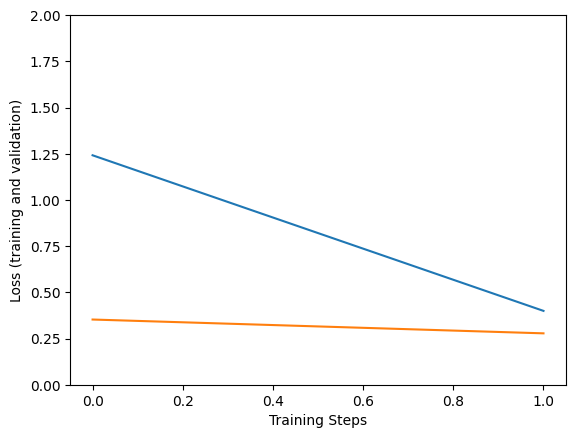

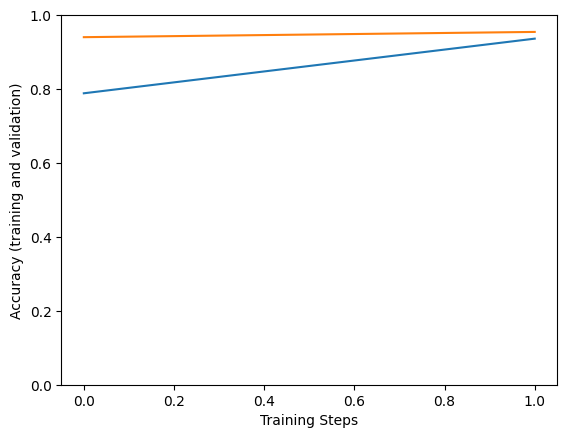

In [ ]:
#hide
plt.figure()
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])

plt.figure()
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(hist["accuracy"])
plt.plot(hist["val_accuracy"])

In [ ]:
if not os.path.exists('/content/drive/MyDrive/ImgSim/'):
    os.mkdir('/content/drive/MyDrive/ImgSim/')

feature_extractor = tf.keras.Model(inputs=model.inputs, outputs=model.layers[-3].output)
feature_extractor.save('/content/drive/MyDrive/ImgSim/bit_feature_extractor', save_format='tf')

saved_model_path = '/content/drive/MyDrive/ImgSim/bit_model'
tf.saved_model.save(model, saved_model_path)

#Image Vectorization

In [ ]:
#hide
import tensorflow as tf
from pathlib import Path
import numpy as np
import os
from tqdm import tqdm
tqdm.pandas()

In [ ]:
img_paths = []
for path in Path('/content/Food_data/categories').rglob('*.jpg'):
  img_paths.append(path)
np.random.shuffle(img_paths)

In [ ]:
def load_img(path):
  img = tf.io.read_file(path)
  img = tf.io.decode_jpeg(img, channels=3)
  img = tf.image.resize_with_pad(img, 224, 224)
  img  = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]
  return img

In [ ]:
#hide-output
TRANSFER_LEARNING_FLAG = 1
if TRANSFER_LEARNING_FLAG:
  module = tf.keras.models.load_model('/content/drive/MyDrive/ImgSim/bit_feature_extractor')
else:
  module_handle = "https://tfhub.dev/google/bit/s-r50x3/ilsvrc2012_classification/1"
  module = hub.load(module_handle)

In [ ]:
imgvec_path = '/content/img_vectors/'
Path(imgvec_path).mkdir(parents=True, exist_ok=True)

In [ ]:
for filename in tqdm(img_paths[:5000]):
    img = load_img(str(filename))
    features = module(img)
    feature_set = np.squeeze(features)
    outfile_name = os.path.basename(filename).split('.')[0] + ".npz"
    out_path_file = os.path.join(imgvec_path, outfile_name)
    np.savetxt(out_path_file, feature_set, delimiter=',')

100%|██████████| 1863/1863 [1:39:16<00:00,  3.20s/it]


# Metadata and Indexing

In [ ]:
#hide
import pandas as pd
import glob
import os
import numpy as np
from tqdm import tqdm
tqdm.pandas()
!pip install -q annoy
import json
from annoy import AnnoyIndex
from scipy import spatial
import pickle
from IPython.display import Image as dispImage

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 647.5/647.5 kB 8.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


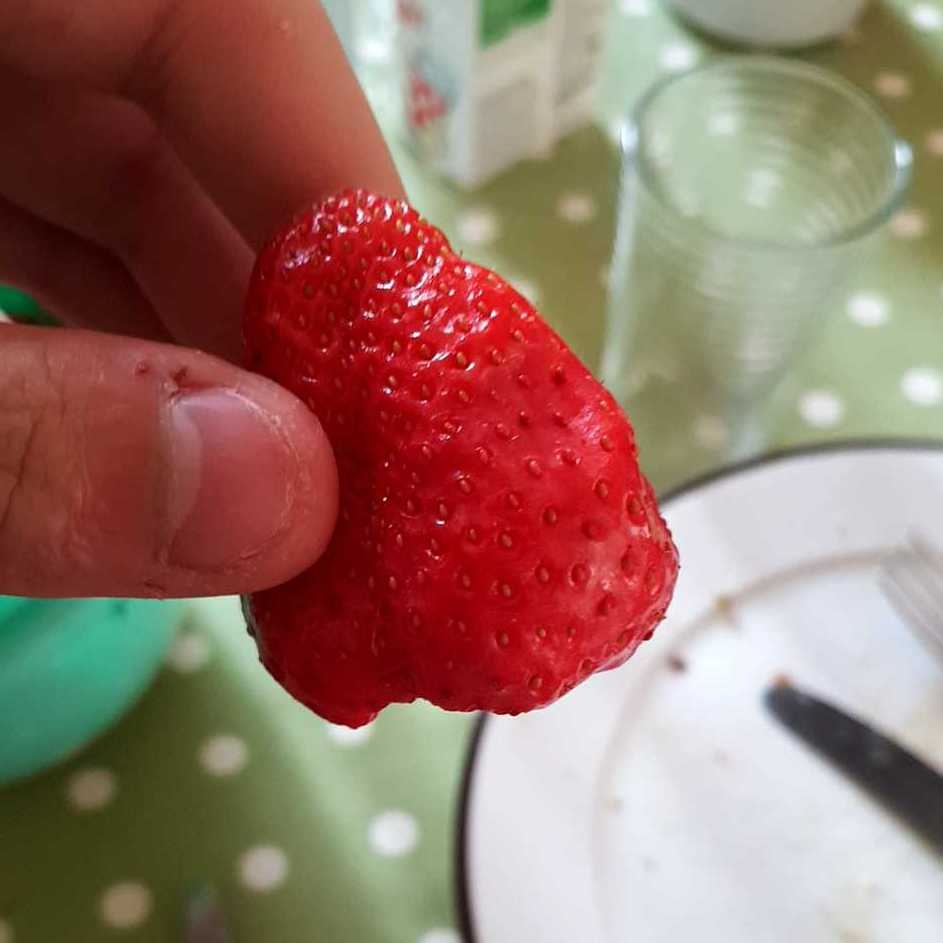

In [ ]:
test_img = '/content/Food_data/categories/strawberries/001b3c460e.jpg'
dispImage(test_img)

In [ ]:
styles = pd.read_csv('/content/train_img.csv', on_bad_lines='skip') # Replace 'error_bad_lines=False' with 'on_bad_lines='skip''
styles['ImageId'] = styles['ImageId'].astype('str')
root_path = '/content'  # Define root_path with the desired directory
styles.to_csv(root_path + '/train_img.csv', index=False) # Now root_path is defined

In [ ]:
def match_id(fname):
  # Changed 'id' to 'ImageId' to match the DataFrame column name
  return styles.index[styles.ImageId==fname].values[0]

In [ ]:
# Defining data structures as empty dict
file_index_to_file_name = {}
file_index_to_file_vector = {}
file_index_to_product_id = {}

# Configuring annoy parametersDataFrame
dims = 256
n_nearest_neighbors = 20
trees = 10000

# Reads all file names which stores feature vectors
allfiles = glob.glob('/content/img_vectors/*.npz')

t = AnnoyIndex(dims, metric='angular')

In [ ]:
for findex, fname in tqdm(enumerate(allfiles)):
  file_vector = np.loadtxt(fname)
  file_name = os.path.basename(fname).split('.')[0]
  file_index_to_file_name[findex] = file_name
  file_index_to_file_vector[findex] = file_vector
  try:
    file_index_to_product_id[findex] = match_id(file_name)
  except IndexError:
    pass
  t.add_item(findex, file_vector)

1863it [00:03, 496.42it/s]


In [ ]:
#hide-output
t.build(trees)
t.save('t.ann')

True

In [ ]:
#hide
file_path = '/content/drive/MyDrive/ImgSim/'

In [ ]:
t.save(file_path+'indexer.ann')
pickle.dump(file_index_to_file_name, open(file_path+"file_index_to_file_name.p", "wb"))
pickle.dump(file_index_to_file_vector, open(file_path+"file_index_to_file_vector.p", "wb"))
pickle.dump(file_index_to_product_id, open(file_path+"file_index_to_product_id.p", "wb"))

# Local Testing

In [ ]:
#hide
from PIL import Image
import matplotlib.image as mpimg

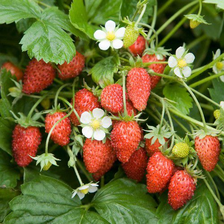

In [ ]:
img_addr = 'https://images.tcdn.com.br/img/img_prod/799330/morango_silvestre_1285_1_20200525111901.jpg'

!wget -q -O img.jpg $img_addr
test_img = 'img.jpg'
topK = 4

test_vec = np.squeeze(module(load_img(test_img)))

basewidth = 224
img = Image.open(test_img)
wpercent = (basewidth/float(img.size[0]))
hsize = int((float(img.size[1])*float(wpercent)))
# Use Image.Resampling.LANCZOS instead of Image.ANTIALIAS
img = img.resize((basewidth,hsize), Image.Resampling.LANCZOS)
img

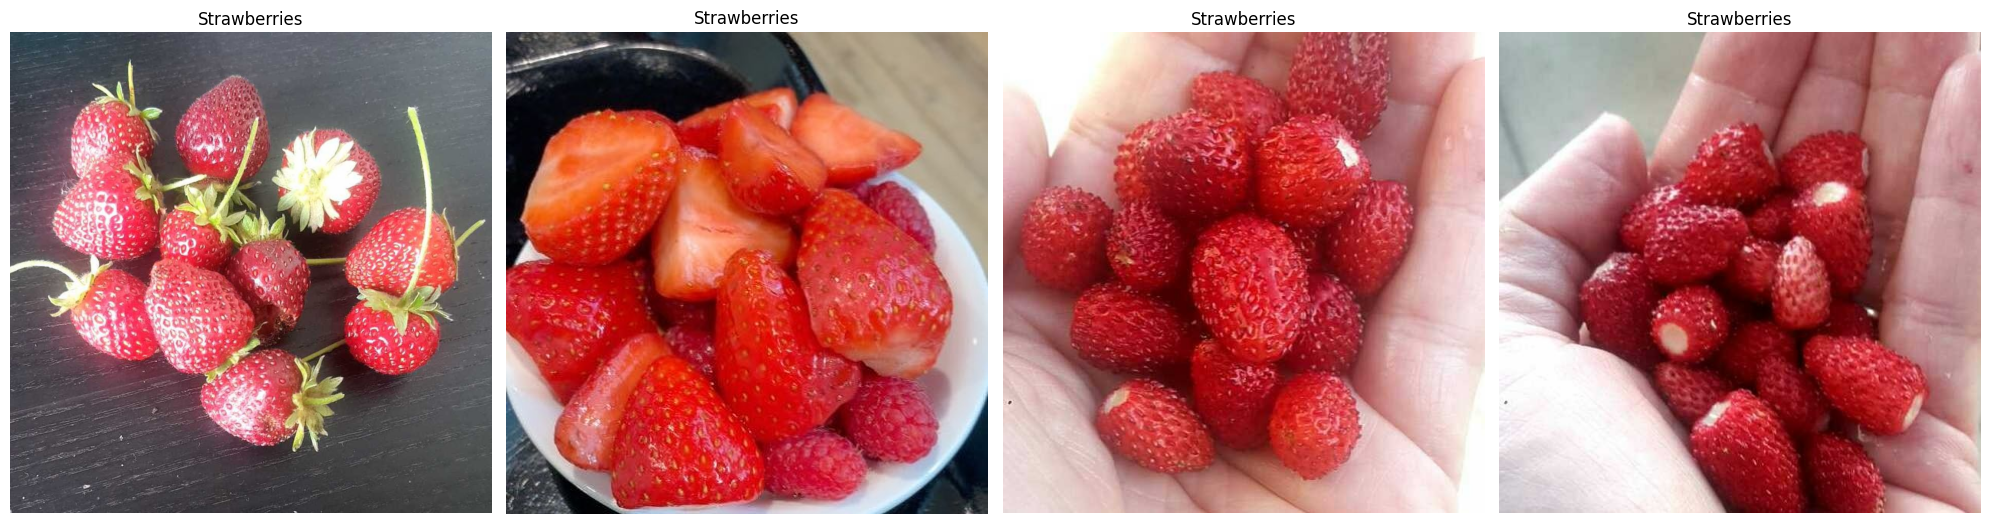

In [ ]:
import matplotlib.pyplot as plt

path_dict = {}
for path in Path('/content/Food_data/categories').rglob('*.jpg'):
  path_dict[path.name] = path

nns = t.get_nns_by_vector(test_vec, n=topK)
plt.figure(figsize=(20, 10))
for i in range(topK):
  x = file_index_to_file_name[nns[i]]
  x = path_dict[x+'.jpg']
  # Check if the key exists before accessing it
  if nns[i] in file_index_to_product_id:
    y = file_index_to_product_id[nns[i]]
    title = '\n'.join([str(j) for j in list(styles.loc[y].values[-5:])])
  else:
    title = "Strawberries"  # Or any other default title
  plt.subplot(1, topK, i+1)
  plt.title(title)
  plt.imshow(mpimg.imread(x))
  plt.axis('off')
plt.tight_layout()